In [2]:
import torch
import triton
import triton.language as tl

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    ]

In [11]:
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def faster_matmul(
    A_ptr, B_ptr, C_ptr,
    M, N, K,
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr
):

    # In naive approach, program Ids are assigned in row-major order
    # But this is bad for L2 cache
    pid = tl.program_id(axis=0)

    # Number of programs along M and N axis
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)

    # Number of programs per group
    num_pid_in_group = GROUP_SIZE_M * num_pid_n

    # Which supergroup the rows belong to
    group_id = pid // num_pid_in_group
    # First row index of the group
    first_pid_m = group_id * GROUP_SIZE_M

    # Ensuring that last group doesn't go out of bounds
    group_size_m = min(GROUP_SIZE_M, num_pid_m - first_pid_m)

    # Computing row and column index
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = ((pid % num_pid_in_group) // group_size_m)

    # Memory offsets for A & B
    off_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    off_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    off_k = tl.arange(0, BLOCK_SIZE_K)

    # Load memory locations for A and B
    A_ptrs = A_ptr + (off_am[:, None] * stride_am + off_k[None, :] * stride_ak)
    B_ptrs = B_ptr + (off_k[:, None] * stride_bk + off_bn[None, :] * stride_bn)

    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(A_ptrs, mask=off_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(B_ptrs, mask=off_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        acc += tl.dot(a, b)

        A_ptrs += BLOCK_SIZE_K * stride_ak
        B_ptrs += BLOCK_SIZE_K * stride_bk

    c = acc.to(tl.float16)

    # Compute output locations
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    C_ptrs = C_ptr + (offs_cm[:, None] * stride_cm + offs_cn[None, :] * stride_cn)

    # Store result
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(C_ptrs, c, mask=c_mask)

In [16]:
def matmul(a, b):
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    M, K = a.shape
    K, N = b.shape

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)

    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    faster_matmul[grid](a, b, c, M, N, K, a.stride(0), a.stride(1), b.stride(0), b.stride(1), c.stride(0), c.stride(1))
    return c

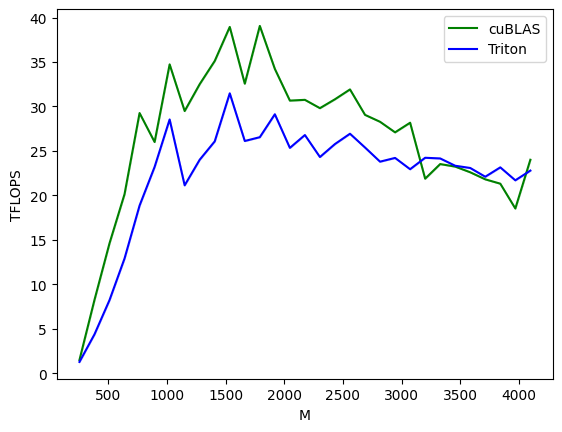

matmul-performance:
         M       N       K     cuBLAS     Triton
0    256.0   256.0   256.0   1.476749   1.261705
1    384.0   384.0   384.0   8.240869   4.364768
2    512.0   512.0   512.0  14.606294   8.216894
3    640.0   640.0   640.0  20.137773  12.899172
4    768.0   768.0   768.0  29.260715  18.851544
5    896.0   896.0   896.0  26.002829  23.199516
6   1024.0  1024.0  1024.0  34.736066  28.538246
7   1152.0  1152.0  1152.0  29.487363  21.129784
8   1280.0  1280.0  1280.0  32.510099  24.008199
9   1408.0  1408.0  1408.0  35.116823  26.072597
10  1536.0  1536.0  1536.0  38.948139  31.479666
11  1664.0  1664.0  1664.0  32.565204  26.116480
12  1792.0  1792.0  1792.0  39.062693  26.545598
13  1920.0  1920.0  1920.0  34.226581  29.123427
14  2048.0  2048.0  2048.0  30.660731  25.341204
15  2176.0  2176.0  2176.0  30.746913  26.786514
16  2304.0  2304.0  2304.0  29.810494  24.313104
17  2432.0  2432.0  2432.0  30.810892  25.773724
18  2560.0  2560.0  2560.0  31.918796  26.933188


In [20]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[128 * i for i in range(2, 33)],
        line_arg="provider",
        line_vals=["cublas", "triton"],
        line_names=["cuBLAS", "Triton"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",
        plot_name="matmul-performance",
        args={},
    )
)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device="cuda", dtype=torch.float16)
    b = torch.randn((K, N), device="cuda", dtype=torch.float16)

    if provider == "cublas":
        ms = triton.testing.do_bench(lambda: torch.matmul(a, b))
    elif provider == "triton":
        ms = triton.testing.do_bench(lambda: matmul(a, b))

    # Compute TFLOPS using the single measured time
    tflops = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return tflops(ms), tflops(ms), tflops(ms)


benchmark.run(show_plots=True, print_data=True)